In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')

In [2]:
def magfield(arx):
    
    print('DATA FROM FILE:      ',arx)

    with h5py.File(arx, "r") as f:
    # List all groups
        a_group_key = list(f.keys())
    
        bmean = np.array(f.get('Bmean'))
    
    return bmean

In [3]:
def readh5files(file,leng):

    print('DATA FROM FILE:      ',file)
    hf = h5py.File(file, 'r')

    x = np.linspace(-0.5,0.5,int(leng))
    y = np.linspace(-0.5,0.5,int(leng))
    z = np.linspace(-0.5,0.5,int(leng))
    rho = np.array(hf.get('rho'))
    vx = np.array(hf.get('vx'))
    vy = np.array(hf.get('vy'))
    vz = np.array(hf.get('vz'))
    Bx = np.array(hf.get('Bx'))
    By = np.array(hf.get('By'))
    Bz = np.array(hf.get('Bz'))

    hf.close()

    print('Dimensions of the grid     :',len(x)," x ",len(y)," x ",len(z))

    return [x,y,z,Bx, By, Bz, vx, vy, vz,rho]

#===========================================================================================

#AVERAGING AND STRESS TENSORS FUNCTION:

def averaging(x,y,z,B,v,rho):

    leng = len(x)
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    dz= z[1]-z[0]
    dV = dx*dy*dz
    dVmatrix = dV*np.ones((len(x),len(y),len(z)))
    V = np.sum(dVmatrix)

    #averaging

    var_dec = [B[0],B[1],B[2],v[0],v[1],v[2],rho]
    meanvar=np.zeros(7)

    print('Averaging of fields...')

    for i in range(0,7):
        integrand = dV*var_dec[i]
        meanvar[i] = np.sum(integrand)/V

    bmean = np.array([meanvar[0],meanvar[1],meanvar[2]])
    vmean = np.array([meanvar[3],meanvar[4],meanvar[5]])
    rhomean = meanvar[6]
    
    #turbulent parts:
    turb = np.zeros((6,len(x),len(y),len(z)))
    for i in range(0,6):
        turb[i] = var_dec[i]-meanvar[i]

    bxturb = turb[0]
    byturb = turb[1]
    bzturb = turb[2]
    vxturb = turb[3]
    vyturb = turb[4]
    vzturb = turb[5]

    #stress tensors:

    print('Stress tensors...')

    bturb = np.array([bxturb, byturb, bzturb])
    vturb = np.array([vxturb, vyturb, vzturb])
    M = np.zeros((3,3,len(x),len(y),len(z)))
    R = np.zeros((3,3,len(x),len(y),len(z)))
    F = np.zeros((3,3,len(x),len(y),len(z)))

    for i in range(0,3):
        for j in range(0,3):
            M[i,j] = bturb[i]*bturb[j]
            R[i,j] = vturb[i]*vturb[j]
            F[i,j] = bturb[j]*vturb[i]-bturb[i]*vturb[j]


    Mmean = np.zeros((3,3))
    Rmean = np.zeros((3,3))
    Fmean = np.zeros((3,3))
    sigmaMsq = np.zeros((3,3))
    sigmaRsq = np.zeros((3,3))
    sigmaFsq = np.zeros((3,3))

    sigmarhosq = np.sum(dV*(rho[:,:]-rhomean)**2)/V

    #averaging of the turbulent stress tensors:
    for i in range(0,3):
        for j in range(0,3):
            Mmean[i,j] = np.sum(M[i,j]*dV)/V
            Rmean[i,j] = np.sum(R[i,j]*dV)/V
            Fmean[i,j] = np.sum(F[i,j]*dV)/V

            sigmaMsq[i,j] = np.sum(dV*(M[i,j,:,:]-Mmean[i,j])**2)/V
            sigmaRsq[i,j] = np.sum(dV*(R[i,j,:,:]-Rmean[i,j])**2)/V
            sigmaFsq[i,j] = np.sum(dV*(F[i,j,:,:]-Fmean[i,j])**2)/V

    print('DONE')

    return bmean, vmean, rhomean, Mmean, Rmean, Fmean, sigmaMsq, sigmaRsq, sigmaFsq, sigmarhosq

def time_evolution(direc,x,y, z, t,leng,bx0):

    lent = len(t)

    print('TIME EVOLUTION')
    
    bmean = []
    vmean = []
    fmean = []
    rhomean = []
    rmean = []
    ferr = []
    rhoerr = []
    rerr = []

    for i in range(0,lent):

        arx = format(i, "08")
        if leng == 512:
            listvar = readh5files(direc+'KHI-h'+str(arx)+'.h5',leng)
        elif leng == 128 or leng == 256:
            listvar = readh5files(direc+'KHI-'+str(arx)+'.h5',leng)

        B = np.array([listvar[3],listvar[4],listvar[5]])
        v = np.array([listvar[6],listvar[7],listvar[8]])
        rho = np.array(listvar[9])

        #averaging:
        print('AVERAGING')

        bmean_t, vmean_t, rhomean_t, Mmean_t, Rmean_t, Fmean_t, sigmaMsq, sigmaRsq, sigmaFsq, sigmarhosq = averaging(x,y,z,B,v,rho)
        
        bmean_t[0] = bmean_t[0]-bx0[0,0,0]
        bmean.append(bmean_t)
        vmean.append(vmean_t)
        fmean.append(Fmean_t)
        rhomean.append(rhomean_t)
        rmean.append(Rmean_t)
        ferr.append(sigmaFsq)
        rhoerr.append(sigmarhosq)
        rerr.append(sigmaRsq)
        
    return fmean,rmean,rhomean,bmean,vmean,ferr,rerr,rhoerr

In [4]:
b0x = '3e-4'
length = 128
if length == 128:
    resu = '128_128_128'
elif length == 256:
    resu = '256_256_256'
elif length == 512:
    resu = '512_512_512'

path_data = "/home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_"+resu
direc = path_data+'/CVP--bx'+b0x+'--'+str(length)+'--rndom/data/'

t = np.linspace(0,40,401)


print('RESOLUTION : ',resu)

if length == 512:
    var = readh5files(direc+'KHI-h00000000.h5',length)
elif length == 128 or length == 256:
    var = readh5files(direc+'KHI-00000000.h5',length)

x = var[0].astype(np.float64)
y = var[1].astype(np.float64)
z = var[2].astype(np.float64)
bx0 = np.array(var[3])

fmean,rmean,rhomean,bmean,vmean,ferr,rerr,rhoerr = time_evolution(direc,x, y, z, t, length,bx0)


RESOLUTION :  128_128_128
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000000.h5
Dimensions of the grid     : 128  x  128  x  128
TIME EVOLUTION
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000000.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000001.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000002.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of 

Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000031.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000032.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000033.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_1

DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000062.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000063.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000064.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000065.h5
Dimensions of the grid     : 128  x  128  x  128
AVE

Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000094.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000095.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000096.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_1

DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000125.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000126.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000127.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000128.h5
Dimensions of the grid     : 128  x  128  x  128
AVE

Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000157.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000158.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000159.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_1

DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000188.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000189.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000190.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000191.h5
Dimensions of the grid     : 128  x  128  x  128
AVE

Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000220.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000221.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000222.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_1

DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000251.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000252.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000253.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000254.h5
Dimensions of the grid     : 128  x  128  x  128
AVE

Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000283.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000284.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000285.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_1

DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000314.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000315.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000316.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000317.h5
Dimensions of the grid     : 128  x  128  x  128
AVE

Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000346.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000347.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000348.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_1

DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000377.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000378.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000379.h5
Dimensions of the grid     : 128  x  128  x  128
AVERAGING
Averaging of fields...
Stress tensors...
DONE
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_128_128_128/CVP--bx3e-4--128--rndom/data/KHI-00000380.h5
Dimensions of the grid     : 128  x  128  x  128
AVE

In [6]:
def energy_dens(Rtensor,rho):
     
    traceR = Rtensor[:,0,0]+Rtensor[:,1,1]+Rtensor[:,2,2]
    energyR = 0.5*rho*traceR

    return energyR

def error_propagation(rho,err_rho,R,err_R,F,err_F,lent):
    
    traceR = R[:,0,0]+R[:,1,1]+R[:,2,2]
    
    e_gammaR = np.zeros((lent,3,3))

    for i in range(0,3):
        for j in range(0,3):        
            e_gammaR[:,i,j] = (err_F[:,i,j]/(0.5*rho[:]**(0.5)*traceR[:])**2+(F[:,i,j]/(0.25*rho[:]**(-1.5)*traceR[:]))**2*err_rho[:]+(F[:,i,j]/(0.5*rho[:]**(0.5)*traceR[:]**2))**2*(err_R[:,0,0]+err_R[:,1,1]+err_R[:,2,2]))**(0.5)
    
    return e_gammaR

In [7]:
ind_ini = 1
ind_fin = 400
told = np.linspace(0,40,401)
#told = told[:-1]
#t = told[1:]
tsat = told[ind_ini:ind_fin]

fmean = np.array(fmean)
rmean = np.array(rmean)
rhomean = np.array(rhomean)
bmean = np.array(bmean)
vmean = np.array(vmean)
ferr = np.array(ferr)
rerr = np.array(rerr)
rhoerr = np.array(rhoerr)
                 
Fsat = fmean[ind_ini:ind_fin]
Rsat = rmean[ind_ini:ind_fin]
bsat = bmean[ind_ini:ind_fin]
vsat = vmean[ind_ini:ind_fin]
rhosat = rhomean[ind_ini:ind_fin]
ferrsat = ferr[ind_ini:ind_fin]
rerrsat = rerr[ind_ini:ind_fin]
rhoerrsat = rhoerr[ind_ini:ind_fin]

energyR = energy_dens(rmean[:],rhomean[:])
energyRsat = energy_dens(Rsat,rhosat)

gamma = []

gamma.append(Fsat[:,0,1]/(bsat[:,2]*energyRsat**(0.5)))
gamma.append(Fsat[:,0,2]/(bsat[:,1]*energyRsat**(0.5)))
gamma.append(Fsat[:,1,2]/(bsat[:,0]*energyRsat**(0.5)))

In [145]:
gamma2 = []

for i in range(0,3):
    for j in range(0,3):
        gamma2.append(Fsat[:,i,j]*rhosat[:]**(0.5)/(energyRsat**(0.5)))

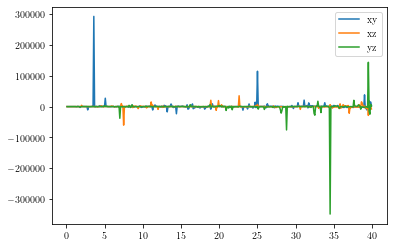

In [8]:
gamma = np.array(gamma)

plt.plot(tsat,gamma[0,:], label = 'xy')
plt.plot(tsat,gamma[1,:], label = 'xz')
plt.plot(tsat,gamma[2,:], label = 'yz')
plt.legend()

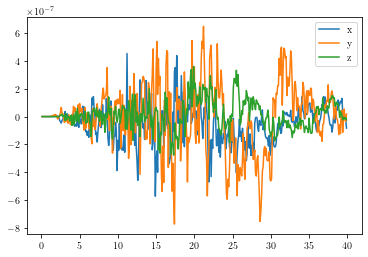

In [9]:
plt.plot(tsat,bsat[:,0], label = 'x')
plt.plot(tsat,bsat[:,1], label = 'y')
plt.plot(tsat,bsat[:,2], label = 'z')
plt.legend()

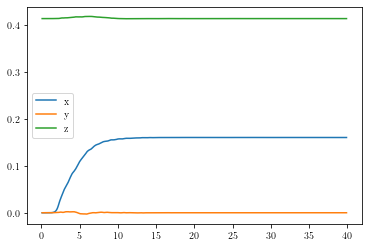

In [14]:
plt.plot(tsat,vsat[:,0], label = 'x')
plt.plot(tsat,vsat[:,1], label = 'y')
plt.plot(tsat,vsat[:,2], label = 'z')
plt.legend()

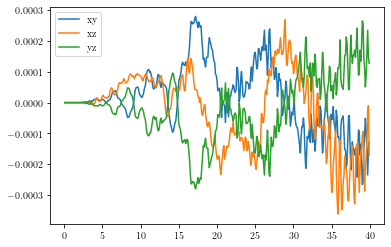

In [146]:
gamma = np.array(gamma2)

plt.plot(tsat,gamma[1,:], label = 'xy')
plt.plot(tsat,gamma[2,:], label = 'xz')
plt.plot(tsat,gamma[3,:], label = 'yz')
plt.legend()

In [119]:
path = 'res_512_512_512/CVP--bx3e-4--512--rndom/mean_quants/'

t = np.linspace(0,40,201)

bmean = np.zeros((len(t),3))

print('Dimensions of the grid : 512x512x512')
print('LOW MAGNETIC FIELD: b_0x = 3e-4')
for i,tt in enumerate(t):
    arx = format(int(10*tt), "04")
    bmean[i,:] = magfield(path+'energies_vxcut_KHI-'+str(arx)+'.h5')
    print('Time           : ',t[i])

Dimensions of the grid : 512x512x512
LOW MAGNETIC FIELD: b_0x = 3e-4
DATA FROM FILE:       res_512_512_512/CVP--bx3e-4--512--rndom/mean_quants/energies_vxcut_KHI-0000.h5
Time           :  0.0
DATA FROM FILE:       res_512_512_512/CVP--bx3e-4--512--rndom/mean_quants/energies_vxcut_KHI-0002.h5
Time           :  0.2
DATA FROM FILE:       res_512_512_512/CVP--bx3e-4--512--rndom/mean_quants/energies_vxcut_KHI-0004.h5
Time           :  0.4
DATA FROM FILE:       res_512_512_512/CVP--bx3e-4--512--rndom/mean_quants/energies_vxcut_KHI-0006.h5
Time           :  0.6000000000000001
DATA FROM FILE:       res_512_512_512/CVP--bx3e-4--512--rndom/mean_quants/energies_vxcut_KHI-0008.h5
Time           :  0.8
DATA FROM FILE:       res_512_512_512/CVP--bx3e-4--512--rndom/mean_quants/energies_vxcut_KHI-0010.h5
Time           :  1.0
DATA FROM FILE:       res_512_512_512/CVP--bx3e-4--512--rndom/mean_quants/energies_vxcut_KHI-0012.h5
Time           :  1.2000000000000002
DATA FROM FILE:       res_512_512_512/CV

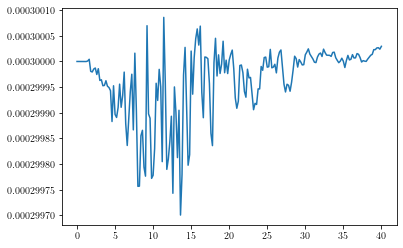

In [120]:
plt.plot(t,bmean[:,0])

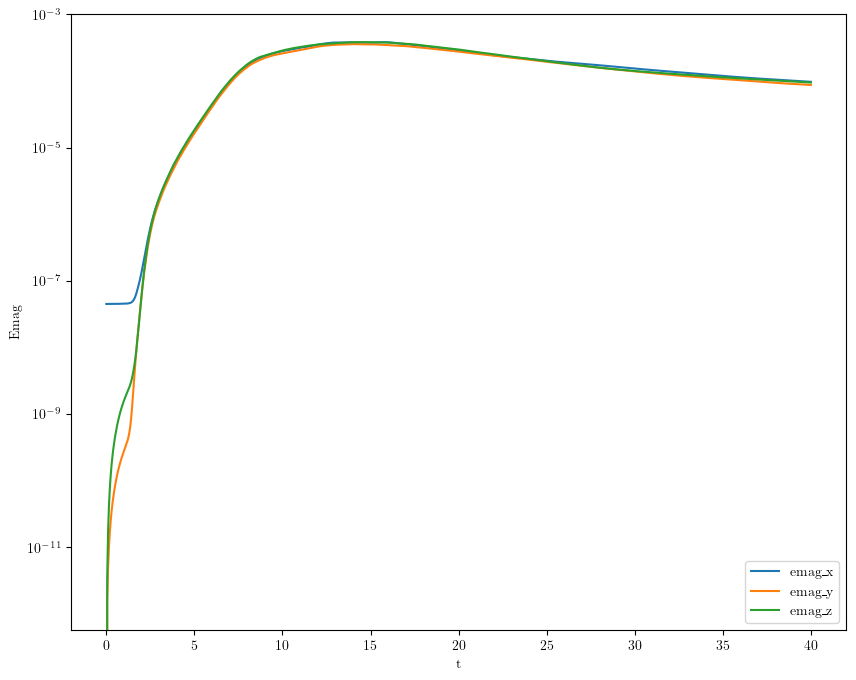

In [17]:
tmag = np.loadtxt(path+'mag.dat',usecols=2)
emagx = np.loadtxt(path+'mag.dat',usecols=4)
emagy = np.loadtxt(path+'mag.dat',usecols=5)
emagz = np.loadtxt(path+'mag.dat',usecols=6)
bxx = np.loadtxt(path+'mag.dat',usecols=7)
bxy = np.loadtxt(path+'mag.dat',usecols=8)
bxz = np.loadtxt(path+'mag.dat',usecols=9)
byy = np.loadtxt(path+'mag.dat',usecols=10)
byz = np.loadtxt(path+'mag.dat',usecols=11)
bzz = np.loadtxt(path+'mag.dat',usecols=12)

fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(tmag,emagx,label = 'emag_x')
ax.plot(tmag,emagy,label = 'emag_y')
ax.plot(tmag,emagz,label = 'emag_z')
ax.set_xlabel('t')
ax.set_ylabel('Emag')
ax.legend(loc='lower right')
ax.set_yscale('log')
plt.show()

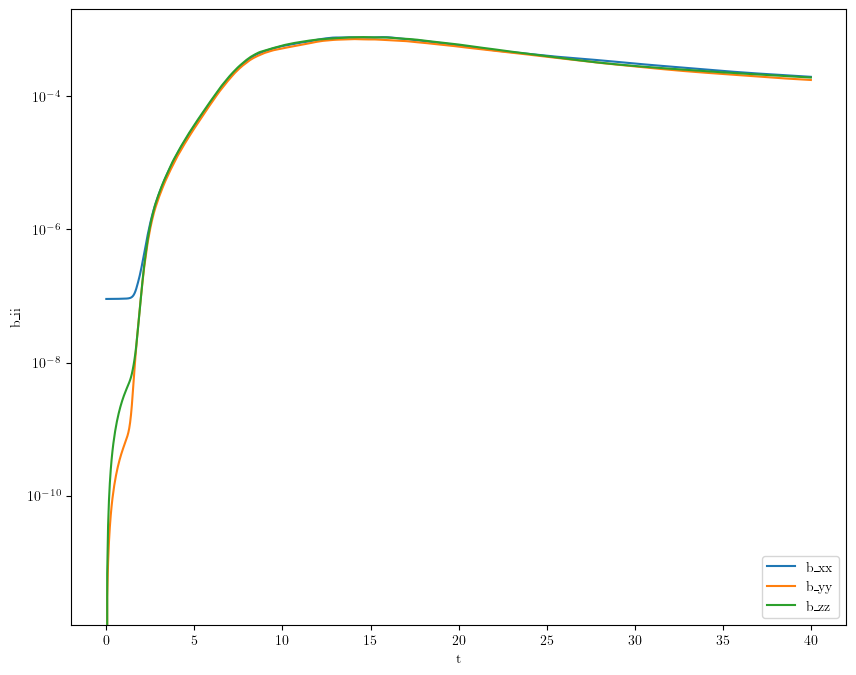

In [18]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(tmag,bxx,label = 'b_xx')
ax.plot(tmag,byy,label = 'b_yy')
ax.plot(tmag,bzz,label = 'b_zz')
ax.set_xlabel('t')
ax.set_ylabel('b_ii')
ax.legend(loc='lower right')
ax.set_yscale('log')
plt.show()

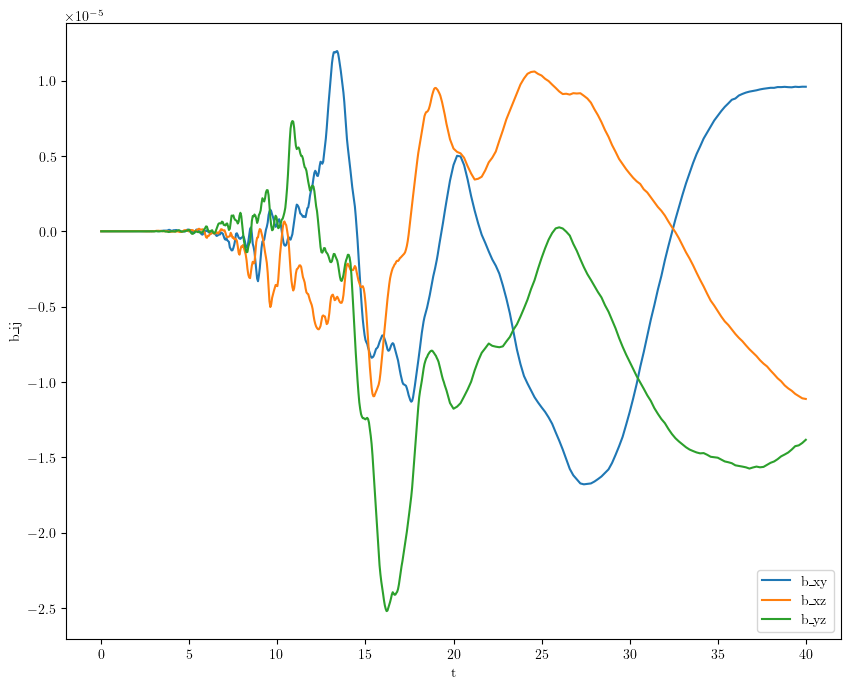

In [19]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(tmag,bxy,label = 'b_xy')
ax.plot(tmag,bxz,label = 'b_xz')
ax.plot(tmag,byz,label = 'b_yz')
ax.set_xlabel('t')
ax.set_ylabel('b_ij')
ax.legend(loc='lower right')
#ax.set_yscale('log')
plt.show()

In [20]:
tvel = np.loadtxt(path+'vel.dat',usecols=2)
evelx = np.loadtxt(path+'vel.dat',usecols=4)
evely = np.loadtxt(path+'vel.dat',usecols=5)
evelz = np.loadtxt(path+'vel.dat',usecols=6)
vxx = np.loadtxt(path+'vel.dat',usecols=7)
vxy = np.loadtxt(path+'vel.dat',usecols=8)
vxz = np.loadtxt(path+'vel.dat',usecols=9)
vyy = np.loadtxt(path+'vel.dat',usecols=10)
vyz = np.loadtxt(path+'vel.dat',usecols=11)
vzz = np.loadtxt(path+'vel.dat',usecols=12)

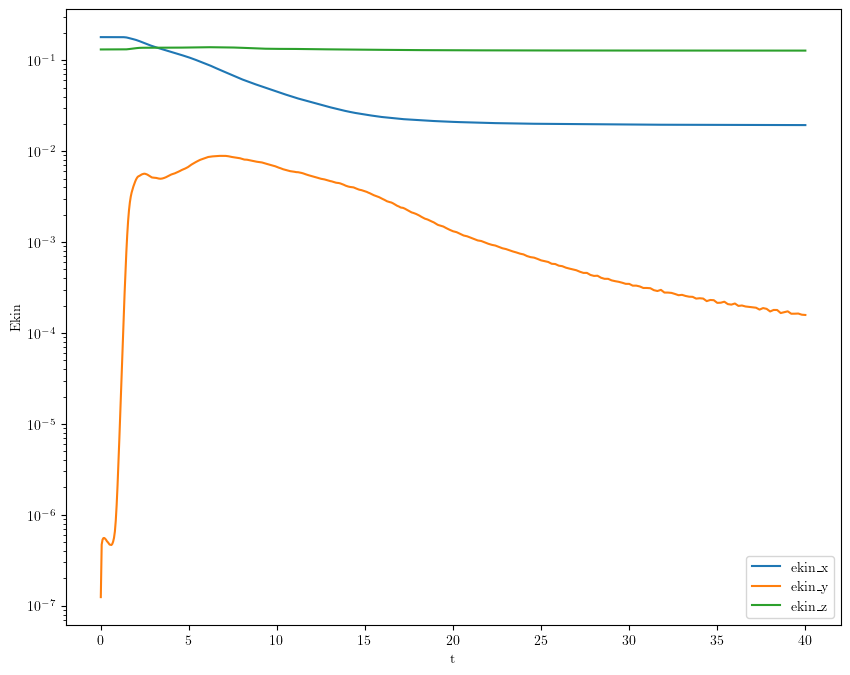

In [22]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(tvel,evelx,label = 'ekin_x')
ax.plot(tvel,evely,label = 'ekin_y')
ax.plot(tvel,evelz,label = 'ekin_z')
ax.set_xlabel('t')
ax.set_ylabel('Ekin')
ax.legend(loc='lower right')
ax.set_yscale('log')
plt.show()

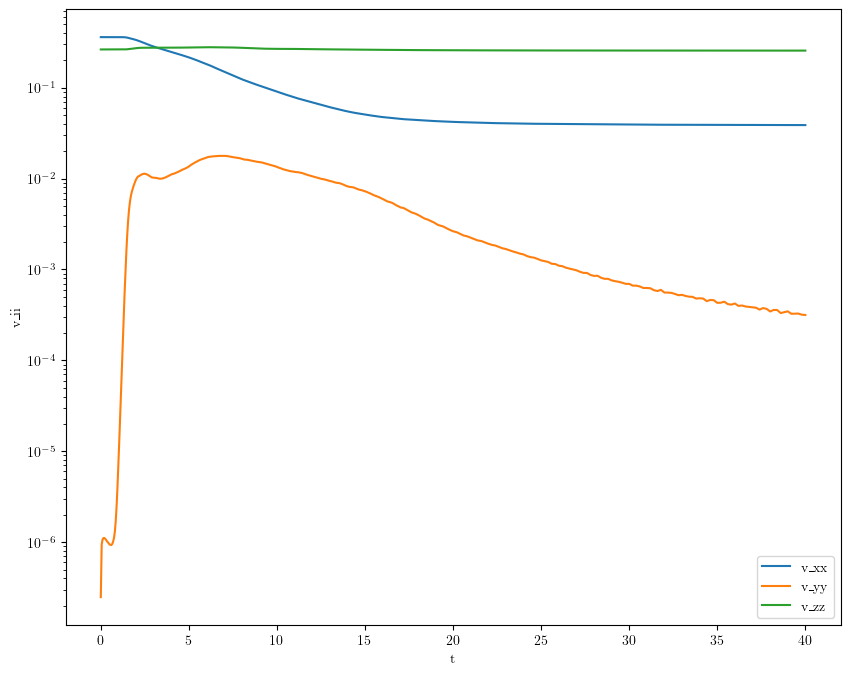

In [23]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(tvel,vxx,label = 'v_xx')
ax.plot(tvel,vyy,label = 'v_yy')
ax.plot(tvel,vzz,label = 'v_zz')
ax.set_xlabel('t')
ax.set_ylabel('v_ii')
ax.legend(loc='lower right')
ax.set_yscale('log')
plt.show()

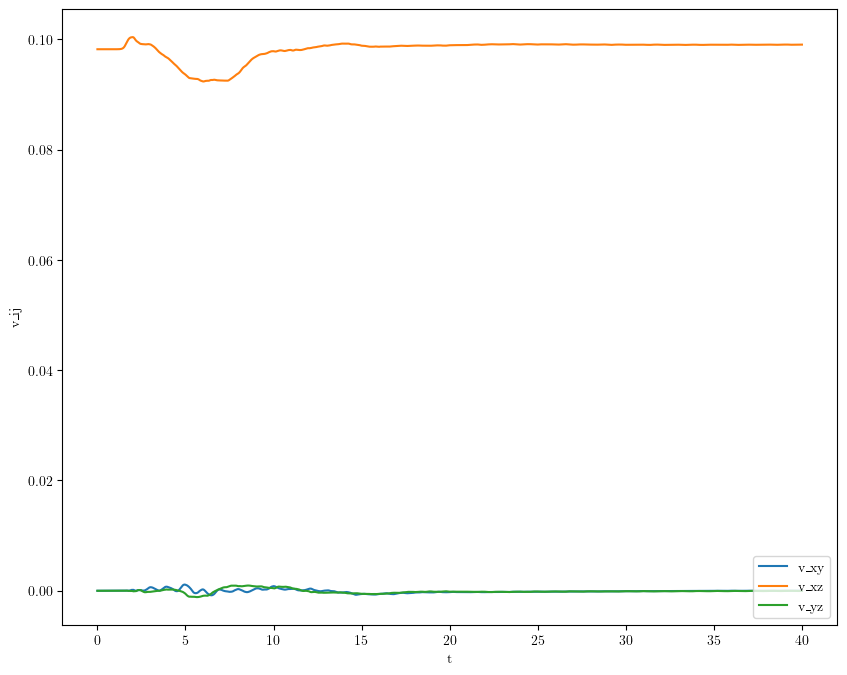

In [26]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(tvel,vxy,label = 'v_xy')
ax.plot(tvel,vxz,label = 'v_xz')
ax.plot(tvel,vyz,label = 'v_yz')
ax.set_xlabel('t')
ax.set_ylabel('v_ij')
ax.legend(loc='lower right')
#ax.set_yscale('log')
plt.show()